# Macrogenesismodel TODO

## Table of contens

TODO
1. Introduction 
2. preparation of XML files by parsing and collecting specific elements
3. relation-element graphs<br>
    3.1. graph for tempsyn relation-elements<br>
    3.2. graph for temppre relation-elements
4. date-element graph & the whole graph
5. First analysis ideas & concepts<br>
    5.1. Rank sources by normed research scores <br>
    5.2. Removing nodes and edges by critical sources<br>
6. ...<br>
    6.1. Performance comparison of all approaches<br>
TODO

In [1]:
from faust_macrogen_graph import parserutils, analyzeutils, graphutils, eades_fas
from macrogenesismodel import fas_test, gengraph
from pathlib import Path
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, HTML
    
special_researchers = {'faust://bibliography/gsa-datenbank' : 1950, 
                     'faust://self' : 2000, 
                     'faust://bibliography/inventare_2_2': 2011, 
                     'faust://bibliography/aa_duw_2': 1974,
                     'faust://print/faustedition/J.2': 1887, 
                     'faust://bibliography/quz_1': 1966, 
                     'faust://bibliography/quz_2': 1982, 
                     'faust://bibliography/quz_3': 1986,
                     'faust://bibliography/quz_4': 1984,
                     'faust://bibliography/wa_I_13_2': 1901, 
                     'faust://bibliography/wa_I_14' : 1887, 
                     'faust://bibliography/wa_I_15_2' : 1888, 
                     'faust://bibliography/wa_I_53': 1914,
                     'faust://bibliography/wa_IV_13' : 1893}

## 1. Introduction

In this notebook we take a detailed look at the macrogenesis of the <b>Faust</b> edition. As explained in the Readme (see: <i>Readme.md</i>), the manuscripts hold the problem that a ordering of all these manuscript by dates isn't possible. One of the reasons are the contradictory datings. These are due to the fact that the inclusion of the various research opinions induces different datings. The goal of the macrogenesis is to create an order with a <b>graph</b> as structure.<br> A graph can be sorted topologically and thus realize the goal of the ordered macrogenesis. To create a topological order the graph has to be acyclic. Due to the contradictions, however, it is not acyclic. To obtain an acyclic graph, edges must be removed. The removed set of edges to make a graph acyclic is called <b>FAS</b> (= Feedback Arc Set or Feedback Edge Set). The algorithm we will use to compute a minimal FAS (MFAS) is by Peter <b>Eades</b> because it is simple, effective and doesn't need a lot of computing power.<br><br>
In this notebook we will rely on the following three main questions:
1. How can we integrate the absolute datings? How does the FAS look like with and without absolute datings?
2. Can a more detailed analysis of the number of edges and the number of contradictions be helpful to decide which edges of which source should be removed?
3. Can erroneously removed edges be re-added without sacrificing performance? How can this be done and how many edges can be re-added?

TODO: explaination of steps (first some parameters, which will be tested later more detailed)<br>
Now follows a short overview of the sections:<br>
<b>Section 2 &amp; 3</b>: In this sections we generate the graph out of three different graphs. In section 3.1 we generate graphs based on the @temppre- and @tempsyn-relation-elements. In section 3.2 we combine the relation graphs with a generated graph based on the date-elements. Unlike the relation graphs, there are several variants of the date-graph, which is due to the different approaches how to implement the absolute dates. We partly answer the first main question how the integration of the absolute datings look like by comparing the different approaches and choosing the best performing approach for the integration into the graph(?). A deeper and more detailed comparison of the approaches will appear in <b>section TODO </b>(?).<br>
<b>Section 4</b>: partly answer of question 2, more in chapter TODO<br>
<b>Section 5</b>:



TODO: more, überarbeiten

## 2. preparation of XML files by parsing and collecting specific elements

The <i>xmlparser</i>-function can take up to four arguments: 
1. the path to the XML files
2. A boolean, if the parser should parse the date- or relation-elements
3. A boolean, if the parser should parse the @temppre- or @tempsyn-relation-elements when it parses the relation-elements
4. A boolean, if the date-elements with the @ignore=yes-attribute will be skipped or not.

In [2]:
filespath = Path('resources')
temppre_items = parserutils.xmlparser(filespath)
tempsyn_items = parserutils.xmlparser(filespath, False, False)
date_items = parserutils.xmlparser(filespath, True, skipignore=False)

## 3. Generating the graph and computing the FAS

### 3.1. graph for temppre relation-elements 

First we create a graph only based of the relation elements with the @tempsyn- and @temppre-attributes. We use this graph later for adding it with the graph based on the relation elements with the date elements. The difference between the two graphs is that an edge within the tempsyn-graph will get the weight 5.0 and an edge within the temppre-graph will get the weight 1.0. For both graphs we check if the computing of a FAS is possible. Finally we merge them together to the graph <b>tempG</b>.

In [3]:
tempsynG = nx.DiGraph()
for t in tempsyn_items:
    graphutils.add_egdes_from_node_list(tempsynG, t)
    
if nx.is_directed_acyclic_graph(tempsynG) == True:
    print("The tempsyn graph is acyclic!")
else:
    tempsynG_fas = eades_fas.eades_FAS(tempsynG, True)

    #atempysnG = acyclic tempsyn Graph
    atempsynG = tempsynG.copy()
    atempsynG.remove_edges_from(tempsynG_fas)
    if nx.is_directed_acyclic_graph(atempsynG) == True:
        print("The tempsyn graph without the FAS (" + str(len(tempsynG_fas)) + " edges) is acyclic!")

The tempsyn graph without the FAS (8 edges) is acyclic!


In [4]:
temppreG = nx.DiGraph()
for t in temppre_items:
    graphutils.add_egdes_from_node_list(temppreG, t)


if nx.is_directed_acyclic_graph(temppreG) == True:
    print("The temppre graph is acyclic!")
else:
    temppreG_fas = eades_fas.eades_FAS(temppreG, True)
    
    #atemppreG: acyclic temppre Graph
    atemppreG = temppreG.copy()
    atemppreG.remove_edges_from(temppreG_fas)
    if nx.is_directed_acyclic_graph(atemppreG) == True:
        print("The temppre graph without the FAS (" + str(len(temppreG_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (68 edges) is acyclic!


In [5]:
tempG = nx.compose(tempsynG, temppreG)

if nx.is_directed_acyclic_graph(tempG) == True:
    print("The temppre graph is acyclic!")
else:
    tempG_fas = eades_fas.eades_FAS(tempG, True)
    
    #atemppreG: acyclic temppre Graph
    atempG = tempG.copy()
    atempG.remove_edges_from(tempG_fas)
    if nx.is_directed_acyclic_graph(atempG) == True:
        print("The temppre graph without the FAS (" + str(len(tempG_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (81 edges) is acyclic!


### 3.2. date-element graph & the whole graph

For the creation of the date graph we got several approaches of which three doesn't induce a FAS by themselves. As shown by the DataFrame <b>dategraphdf</b>, only the approaches of <b>Vitt</b> and <b>shorter_period</b> induce a FAS by themselves. The reason behind this is that the approaches of <b>Wissenbach, Paulus-1</b> and <b>Paulus-2</b> are not designed to work by themselves.<br> The visualization of the approach of <b>Wissenbach</b> (see resources/vitt_macrogen.pdf, p. 12) shows that it should only be used in conjunction with the tempsyn-elements.<br> The approaches <b>Paulus-1</b> and <b>Paulus-2</b> are made by the author of this notebook and they are for illustrative purposes only.  The basic idea was that that either the "notBefore"-elements or the "notAfter"-elements should be linked to the respective manuscript but not both like the <b>Vitt</b>-approach. Although this did not create a FAS, the number of nodes and edges was much smaller than the <b>Vitt</b>-approach.TODO: more?<br>
The approach <b>longer_period</b> is as well as the <b>shorter_period</b>-approach a variant of the <b>Vitt</b>-approach and will be later explained in detail in section ??? (TODO).

In [6]:
approaches = ["vitt", "wissenbach", "paulus-1", "paulus-2", "shorter_period", "longer_period"]
dategraphdf = analyzeutils.compare_approaches(approaches, special_researchers)
dategraphdf

,n nodes,n edges,n cycles,n feedback edges
vitt,731,687,18,18
wissenbach,689,441,0,0
paulus-1,655,441,0,0
paulus-2,649,441,0,0
shorter_period,784,687,18,18
longer_period,781,687,0,0


TODO<br>
Since not all approaches generated a FAS on their own, a graph must be created from the relation and date elements and the approaches shall be compared again based on the new graph.

In [7]:
analyzeutils.compare_approaches(approaches, special_researchers, True)

,n nodes,n edges,n cycles,n feedback edges
vitt,967,1643,1711,120
wissenbach,925,1397,480,68
paulus-1,891,1397,480,68
paulus-2,885,1397,480,68
shorter_period,1020,1643,1179,113
longer_period,1017,1643,620,71


TODO. more approaches? explain approaches?<br>
The new comparison shows that the <b>Vitt</b>-approach is superior to the other approaches if we omit the approaches <b>shorter_period</b> and <b>longer_period</b>. For the moment, they are left out because, as already mentioned, they are a variant of the <b>Vitt</b> approach and a more detailed analysis of the two approaches will be done in Section ? (TODO).<br> So we will take the Vitt approach first to represent the date-elements within the graph. 

In [8]:
datesG = graphutils.graph_from_dates(date_items, "vitt", special_researchers)
G = nx.compose(tempG, datesG)
G_fas = eades_fas.eades_FAS(G, True)
aG = G.copy()
aG.remove_edges_from(G_fas)
if nx.is_directed_acyclic_graph(aG) == True:
    print("The temppre graph without the FAS (" + str(len(G_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (130 edges) is acyclic!


TODO
The FAS for the whole Graph contains 120 edges. The whole graph G contains 1677 edges, so 7% of all edges are in the FAS. This percentage is too high and several solution approaches should be tried out to reduce this percentage.

In [9]:
print(str(int((len(G_fas) / len(G.edges())) * 100)) 
      + "% of all edges (" + str(len(G.edges())) 
      + ") of G are in the FAS (" + str(len(G_fas)) + " edges).")

7% of all edges (1677) of G are in the FAS (130 edges).


## 4. First analysis ideas & concepts

### 4.1. Rank sources by normed research scores

TODO
Kapitel erst später?
TODO
Grundidee hier erklären? FAS ist zwar toll, aber leider zufällig, da es probiert, minimal zu sein. wir wollen aber eventuell ganze widersprüchliche Quellen entfernen als nur einzelne Kanten.

In this chapter we take a look at the source attributes of the edges. In the XML files, a dating is attested by a source. The problem is that these sources contradict each other which is certainly the reason for the existance of the FAS. To make the graph acyclic, we have to get rid of these contradictory statements.<br>
We parse through the "source"-attributes of the edges of the graph and return a Counter with a frequency score assigned to each researcher. The idea behind this is that a researcher who contributed more than others will get a much higher score. The problem is that by this method quantity surpasses quality. It is not that simple to compare two academic works by its quality and the resulting benefit for the research because the comparison possibilities are manifold and a detailed comparison would exceed this work. As simplification we adjust the scores by multiplying each score with a normalized year of the publication of the researchers work about <b>Faust</b>.

<u>An example</u>: <br>
Anne Bohnenkamp released her work „… das Hauptgeschäft nicht außer Augen lassend“ 1994. Her work is used as source 337 times within the Faustedition. After the "Weimarer Ausgabe, Abt. I, Bd. 15,2, Weimar 1888" (wa_I_15_2), she is the most named source for datings. 

min_range: 1770 (Goethe began to work on his "Urfaust" 1770) <br>
max_range: 2017 (According to http://www.faustedition.net/bibliography, the youngest considered work about Faust beside the Faustedition is <i>Brüning / Hahn 2017</i>.)

Bohnenkamp 1994: 354 * ((1994 - 1770) / (2017 - 1770)) = 321.036437

After the normalization Bohnenkamp surpasses the "wa_I_15_2" (see the source DataFrame <i>source_df</i>). We simply assume in this work that datings of newer works are better and more accurately than older works. One of the reasonings behind this is that newer works are able to make their statements against the background of older researchs, while the older researchs are unable to do so. The normalized score will be used in the next section.

In [10]:
#df with research count scores
research_scores = analyzeutils.get_research_score(G)
sorted_research_scores = {k: research_scores[k] 
                              for k in sorted(research_scores, key=research_scores.get, reverse=True)}
research_df = pd.DataFrame(sorted_research_scores.items(), columns=["source", "year_frequency"])
research_df.set_index("source", inplace=True)

#df with normed research count scores
norm_research_scores = analyzeutils.get_norm_research_score(G, special_researchers, 1770, 2017)
sorted_norm_research_scores = {k: norm_research_scores[k]
                              for k in sorted(norm_research_scores, key=norm_research_scores.get, reverse=True)}

norm_research_df = pd.DataFrame(sorted_norm_research_scores.items(), columns=["source", "norm_year_frequency"])
norm_research_df.set_index("source", inplace=True)


#combinig the dfs
source_df = research_df.join(norm_research_df)
source_df[:10]

,year_frequency,norm_year_frequency
source,,
faust://bibliography/wa_I_15_2,450,214.979757
faust://bibliography/bohnenkamp1994,354,321.036437
faust://bibliography/fischer-lamberg1955,346,259.149798
faust://bibliography/landeck1981,142,121.303644
faust://self,140,130.364372
faust://bibliography/hertz1932,76,49.846154
faust://bibliography/gsa-datenbank,27,19.676113
faust://bibliography/inventare_2_2,26,25.368421
faust://bibliography/hertz1931,12,7.821862


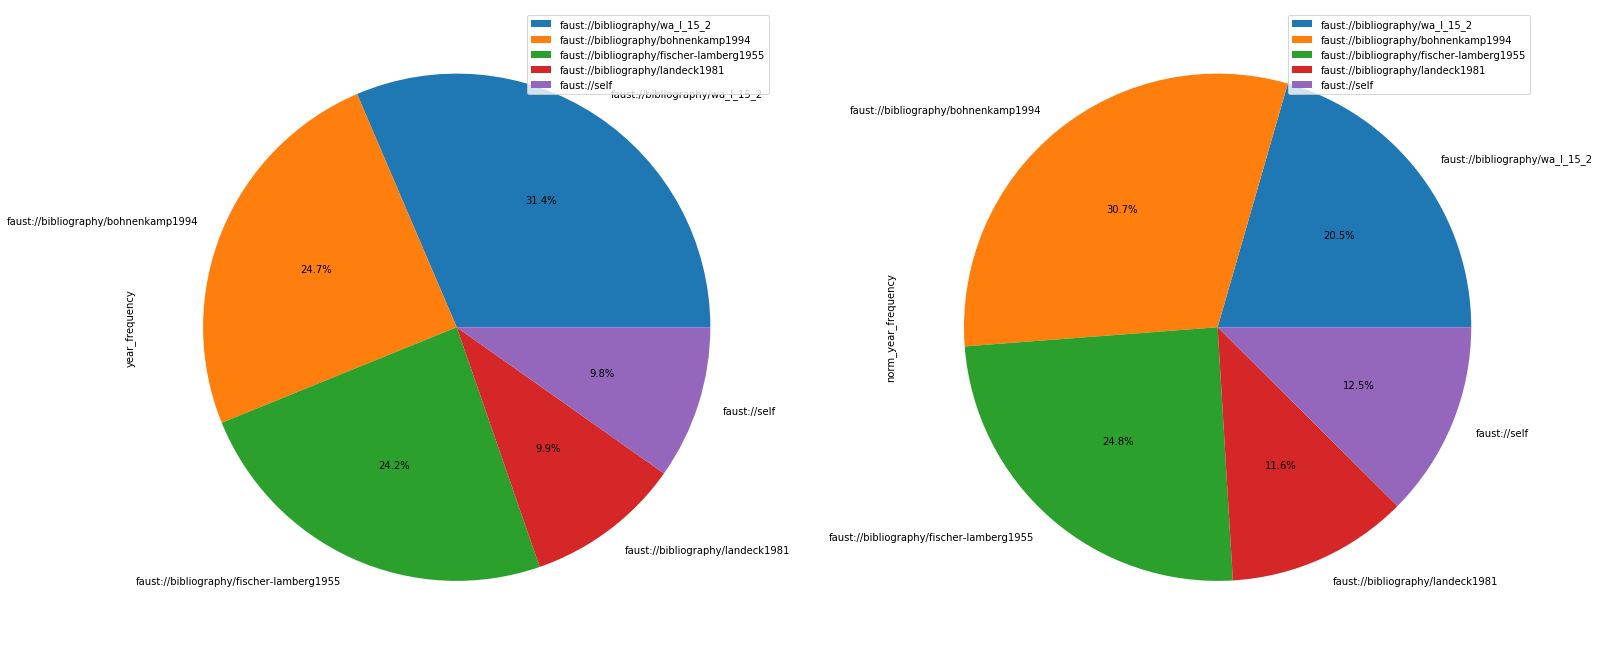

In [11]:
plot = source_df[:5].plot.pie(subplots=True, figsize=(25,25), autopct='%.1f%%')
plt.show()

In [12]:
#df with publication year of the source
year_scores = analyzeutils.get_source_year(G, special_researchers)
year_df = pd.DataFrame(year_scores.items(), columns=["source", "pub_year"])
year_df.set_index("source", inplace=True)

#adding it to the source_df
source_df = source_df.join(year_df)
source_df[:10]

,year_frequency,norm_year_frequency,pub_year
source,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888
faust://bibliography/bohnenkamp1994,354,321.036437,1994
faust://bibliography/fischer-lamberg1955,346,259.149798,1955
faust://bibliography/landeck1981,142,121.303644,1981
faust://self,140,130.364372,2000
faust://bibliography/hertz1932,76,49.846154,1932
faust://bibliography/gsa-datenbank,27,19.676113,1950
faust://bibliography/inventare_2_2,26,25.368421,2011
faust://bibliography/hertz1931,12,7.821862,1931


### 4.2. Removing nodes and edges by critical sources

After the normalization of the source counts we have to take a deeper look at the <b>Feedback Arc Set</b>. The FAS contains 130 edges. More than a third of the FAS is taken up by "wa_I_15_2" and more than twice as much as the second, third and fourth most common sources by "fischer-lamberg1955", "bohnenkamp1994" and "landeck1981" (see the FAS-frequency DataFrame <i>fasfrequency_df</i>).<br> In this section we try to bypass the computed FAS by trying to make the graph <b>G</b> acylic with the removal of specific sources. We rely on the normed research score of the previous section (see 4.1). The idea behind this is that the FAS has a certain randomness because it tries to compute a minimal solution for the problem (at least if we use the <b>Eades</b> or any other MFAS algorithm). This holds the problem that the removal of the edges to make the graph <b>G</b> acyclic and its randomness makes little sense with regards of content. Against the background of an ideal solution which returns a perfect sorting, the goal is rather to find critical, conflicting sources. Nevertheless, we use the FAS to filter for critical sources and take a closer look a the sources who have the most edges within the FAS.

For a better content but also visual comparison we will use the datastructure <i>DataFrame</i> from the <i>pandas library</i>. The DataFrame <i>df</i> which represents the comparison will be build step by step. The sources of the edges of the FAS determine the index of the DataFrame and the

- frequency of the researcher as manuscript source
- normed frequency of the researcher as manuscript source
- publication year of the source
- frequency of the researcher as source of an edge in the FAS
- percentage which determines how many edges of an researcher are in the FAS
- percentage which determines how many edges of an researcher (based on the normalized year frequency) are in the FAS

determine the six columns. Each of these columns will be first stored in a DataFrame and later added to the "main"-DataFrame <i>df</i> which is gradually being expanded.
<br>TODO: more!?

In [13]:
#frequency of the researcher as manuscript source
fasfrequency_df = analyzeutils.gen_frequencyfas(G)
fasfrequency_df

,fas_frequency
source,
faust://bibliography/wa_I_15_2,51
faust://bibliography/fischer-lamberg1955,24
faust://bibliography/bohnenkamp1994,19
faust://bibliography/landeck1981,17
faust://bibliography/hertz1932,7
faust://self,3
faust://bibliography/pniower1899,3
faust://bibliography/hertz1931,1
faust://bibliography/bluhm1966,1


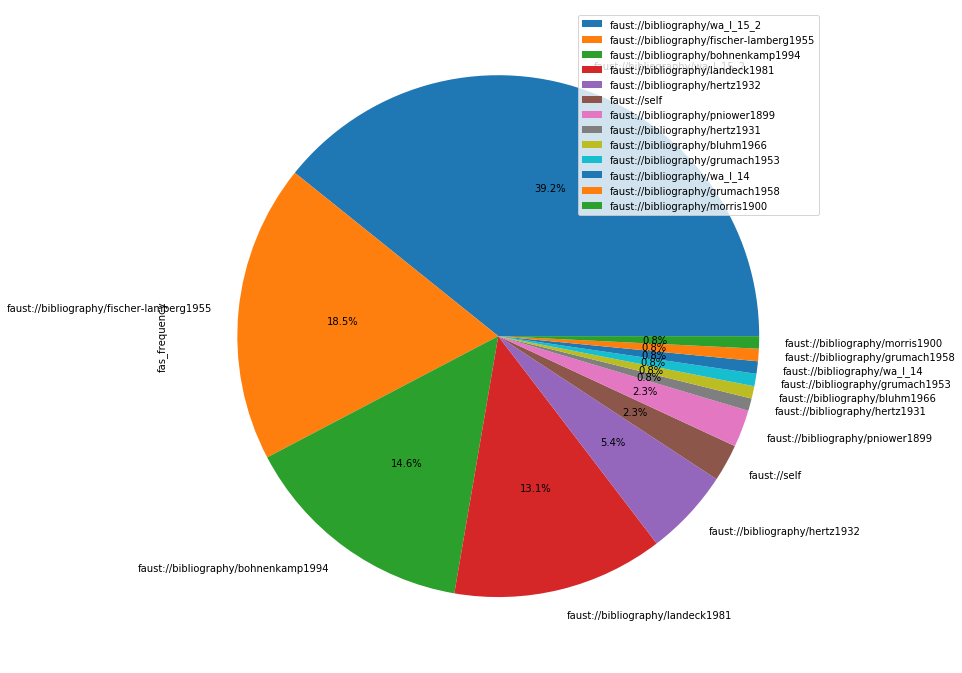

In [14]:
plot = fasfrequency_df.plot.pie(y="fas_frequency", figsize=(12, 12), autopct='%.1f%%')
plt.show()

In [15]:
df = source_df.join(fasfrequency_df)
df = df.dropna() #only sources which are inside the FAS
df

,year_frequency,norm_year_frequency,pub_year,fas_frequency
source,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,51.0
faust://bibliography/bohnenkamp1994,354,321.036437,1994,19.0
faust://bibliography/fischer-lamberg1955,346,259.149798,1955,24.0
faust://bibliography/landeck1981,142,121.303644,1981,17.0
faust://self,140,130.364372,2000,3.0
faust://bibliography/hertz1932,76,49.846154,1932,7.0
faust://bibliography/hertz1931,12,7.821862,1931,1.0
faust://bibliography/wa_I_14,10,4.736842,1887,1.0
faust://bibliography/pniower1899,7,3.655870,1899,3.0


TODO: explain

In [16]:
percent_fas = (df["fas_frequency"] / df["year_frequency"]) * 100
norm_percent_fas = (df["fas_frequency"] / df["norm_year_frequency"]) * 100
percentfas_df = pd.concat([percent_fas, norm_percent_fas], axis=1, sort=True)
percentfas_df = percentfas_df.rename(columns={0:"percent_fas", 1:"norm_percent_fas"})
percentfas_df.sort_values(by="percent_fas", ascending=False)
df = df.join(percentfas_df, on="source")
df
#Note: If the following Error raises, restart the code cell with the "df"-variable and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,pub_year,fas_frequency,percent_fas,norm_percent_fas
source,,,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,51.0,11.333333,23.723164
faust://bibliography/bohnenkamp1994,354,321.036437,1994,19.0,5.367232,5.918331
faust://bibliography/fischer-lamberg1955,346,259.149798,1955,24.0,6.936416,9.261053
faust://bibliography/landeck1981,142,121.303644,1981,17.0,11.971831,14.014418
faust://self,140,130.364372,2000,3.0,2.142857,2.301242
faust://bibliography/hertz1932,76,49.846154,1932,7.0,9.210526,14.043210
faust://bibliography/hertz1931,12,7.821862,1931,1.0,8.333333,12.784679
faust://bibliography/wa_I_14,10,4.736842,1887,1.0,10.000000,21.111111
faust://bibliography/pniower1899,7,3.655870,1899,3.0,42.857143,82.059801


For answering the question which complete source we want to remove to make the Graph acyclic without computing a FAS, we rely on several characteristics a source should have to be rather removed from the Graph than other sources:
1. Very old source 
2. Small amount of edges in the Graph
3. Resulting from (1) and (2) a high <b>norm_percent_fas</b>-score.
4. ? TODO

If a source meets many of the mentioned characteristics, we remove every edge with the source as attribute and compare how much the FAS shrinkes afterwards.

We remove every source of the <b>df</b> from the graph and store the reduced <b>FAS</b> with the assigned source in dictionary.

In [17]:
critical_sources_fas = analyzeutils.gen_critical_sources(G, dict(df["norm_percent_fas"]))
critical_sources_fas

{'faust://bibliography/wa_I_15_2': 52,
 'faust://bibliography/bohnenkamp1994': 99,
 'faust://bibliography/fischer-lamberg1955': 83,
 'faust://bibliography/landeck1981': 107,
 'faust://self': 125,
 'faust://bibliography/hertz1932': 108,
 'faust://bibliography/hertz1931': 129,
 'faust://bibliography/wa_I_14': 129,
 'faust://bibliography/pniower1899': 126,
 'faust://bibliography/grumach1953': 129,
 'faust://bibliography/grumach1958': 129,
 'faust://bibliography/morris1900': 132,
 'faust://bibliography/bluhm1966': 129}

In [18]:
criticals_df = pd.DataFrame(critical_sources_fas.items(), columns=["source", "fas_without_source"])
criticals_df.set_index("source", inplace=True)
df = df.join(criticals_df)
df
#Note: If the following Error raises or the column "fas_without_source" contains only NaN values, 
#restart the code cell with the creation of "df" and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,pub_year,fas_frequency,percent_fas,norm_percent_fas,fas_without_source
source,,,,,,,
faust://bibliography/wa_I_15_2,450,214.979757,1888,51.0,11.333333,23.723164,52
faust://bibliography/bohnenkamp1994,354,321.036437,1994,19.0,5.367232,5.918331,99
faust://bibliography/fischer-lamberg1955,346,259.149798,1955,24.0,6.936416,9.261053,83
faust://bibliography/landeck1981,142,121.303644,1981,17.0,11.971831,14.014418,107
faust://self,140,130.364372,2000,3.0,2.142857,2.301242,125
faust://bibliography/hertz1932,76,49.846154,1932,7.0,9.210526,14.043210,108
faust://bibliography/hertz1931,12,7.821862,1931,1.0,8.333333,12.784679,129
faust://bibliography/wa_I_14,10,4.736842,1887,1.0,10.000000,21.111111,129
faust://bibliography/pniower1899,7,3.655870,1899,3.0,42.857143,82.059801,126


We now take a look at the sources which didn't appear in the "original" FAS and add them to the <b>possible_critical_sources</b>-dictionary if a removal of these sources reduce the FAS.

In [19]:
#TODO explain (die möglichen FAS kandidaten die durch df.drop_na außen vorgelassen wurden)

#scores of all 
scores_all_sources = dict(analyzeutils.get_research_score(G))
all_critical_sources_fas = analyzeutils.gen_critical_sources(G, scores_all_sources)


possible_critical_sources = {}
for k,v in dict(all_critical_sources_fas).items():
    if k not in list(df.index.values) and v < 130:
        possible_critical_sources[k] = v
possible_critical_sources

{'faust://bibliography/inventare_2_2': 127}

In this section we:
- build a DataFrame <i>df</i> where we took the sources of the FAS as index and several characteristics like the "publication year", the "frequency of the source inside the FAS" or the s"ize of the FAS without the source" as columns
- computed a dictionary with possible critical sources which aren't in the "original" FAS but could reduce the FAS when they would be removed (?)
- TODO: noch was?

## 5. Manipulating (?) approaches

### 5.1. Performance comparison of all current approaches

In this section we compare all of the current approaches and look at their performance. We already did this in a light variant in <b>section 3</b>. There we decided to take the Vitt approach because the computed graph hold more nodes and egdes than the other approaches. We now prove in more detail why using the Vitt-approach or definitely the basic idea of the approach is the best solution for us(?).<br>
Instead of simply compare the approaches by the number of nodes and edges, we also test if the ignoring of the skipignore-elements and changing of the <b>Eades</b>-MFAS-algorithm to the variant of <b>Tintelnot</b> make(?) any big difference (?).
TODO

In [20]:
#paramlist = [approach, skipignore, eades_fas or tintelnot_fas]
metaparamdict = {"vitt(+skipignore, tintelnot)" : ["vitt", True, True], 
                 "vitt(-skipignore, tintelnot)" : ["vitt", False, True],
                "vitt(+skipignore, eades)" : ["vitt", True, False], 
                 "vitt(-skipignore, eades)" : ["vitt", False, False],
                "wissenbach(+skipignore, tintelnot)" : ["wissenbach", True, True], 
                 "wissenbach(-skipignore, tinelnot)" : ["wissenbach", False, True],
                "wissenbach(+skipignore, eades)" : ["wissenbach", True, False], 
                 "wissenbach(-skipignore, eades)" : ["wissenbach", False, False],
                 "paulus-1(+skipignore, tintelnot)" : ["paulus-1", True, True], 
                 "paulus-1(-skipignore, tinelnot)" : ["paulus-1", False, True],
                "paulus-1(+skipignore, eades)" : ["paulus-1", True, False], 
                 "paulus-1(-skipignore, eades)" : ["paulus-1", False, False],
                 "paulus-2(+skipignore, tintelnot)" : ["paulus-2", True, True], 
                 "paulus-2(-skipignore, tinelnot)" : ["paulus-2", False, True],
                "paulus-2(+skipignore, eades)" : ["paulus-2", True, False], 
                 "paulus-2(-skipignore, eades)" : ["paulus-2", False, False],
                }
meta_fas_test_dict = {}

for key, paramlist in metaparamdict.items():
    meta_fas_test_dict[key] = fas_test(paramlist, special_researchers)

In [21]:
meta_param_df = pd.DataFrame(meta_fas_test_dict)
meta_param_df = meta_param_df.T
meta_param_df = meta_param_df.drop("nodeslist", 1)
meta_param_df

,cycles,edges,fas,fasfrequency_df,nodes,percentfas_df,source_df
"vitt(+skipignore, tintelnot)",1711,1643,120,fas_...,965,perc...,year...
"vitt(-skipignore, tintelnot)",1711,1643,120,fas_...,967,perc...,year...
"vitt(+skipignore, eades)",1711,1643,120,fas_...,965,perc...,year...
"vitt(-skipignore, eades)",1711,1643,120,fas_...,967,perc...,year...
"wissenbach(+skipignore, tintelnot)",480,1397,68,fas_...,925,perc...,year...
"wissenbach(-skipignore, tinelnot)",480,1397,68,fas_...,925,perc...,year...
"wissenbach(+skipignore, eades)",480,1397,68,fas_...,925,perc...,year...
"wissenbach(-skipignore, eades)",480,1397,68,fas_...,925,perc...,year...
"paulus-1(+skipignore, tintelnot)",480,1397,68,fas_...,891,perc...,year...
"paulus-1(-skipignore, tinelnot)",480,1397,68,fas_...,891,perc...,year...


In [22]:
metadfdict = {"fasfrequency_df" : ["fas_frequency"], 
              "percentfas_df": ["percent_fas","norm_percent_fas"], 
              "source_df": ["year_frequency", "norm_year_frequency"]}



for dataframe, columns in metadfdict.items():
    for column in columns:
        tmp_df = analyzeutils.dataframe_from_column(meta_param_df, dataframe, column)
        print(column)
        display(HTML(tmp_df.to_html()))
        print("\n")

fas_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,18.0,18.0,18.0,18.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
faust://bibliography/fischer-lamberg1955,23.0,23.0,23.0,23.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
faust://bibliography/grumach1958,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/landeck1981,13.0,13.0,13.0,13.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
faust://bibliography/morris1900,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/pniower1899,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




percent_fas


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,50.000000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,5.341246,5.341246,5.341246,5.341246,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846,1.153846
faust://bibliography/fischer-lamberg1955,6.666667,6.666667,6.666667,6.666667,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746,5.084746
faust://bibliography/grumach1958,16.666667,16.666667,16.666667,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,8.333333,8.333333,8.333333,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,4.347826,4.347826,4.347826,4.347826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103,2.564103
faust://bibliography/landeck1981,9.558824,9.558824,9.558824,9.558824,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000,3.200000
faust://bibliography/morris1900,50.000000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/pniower1899,42.857143,42.857143,42.857143,42.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




norm_percent_fas


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/bluhm1966,63.010204,63.010204,63.010204,63.010204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/bohnenkamp1994,5.889678,5.889678,5.889678,5.889678,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321,1.272321
faust://bibliography/fischer-lamberg1955,8.900901,8.900901,8.900901,8.900901,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823,6.788823
faust://bibliography/grumach1958,21.897163,21.897163,21.897163,21.897163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1931,12.784679,12.784679,12.784679,12.784679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/hertz1932,6.629093,6.629093,6.629093,6.629093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/inventare_2_2,NaN,NaN,NaN,NaN,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939,2.627939
faust://bibliography/landeck1981,11.189713,11.189713,11.189713,11.189713,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972,3.745972
faust://bibliography/morris1900,95.000000,95.000000,95.000000,95.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/pniower1899,82.059801,82.059801,82.059801,82.059801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




year_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/aa_duw_2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/bluhm1966,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
faust://bibliography/bohnenkamp1994,337.0,337.0,337.0,337.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0,260.0
faust://bibliography/bruening_hahn2017,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/collin1920,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891a,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891b,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/fischer-lamberg1955,345.0,345.0,345.0,345.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0,295.0
faust://bibliography/fischer-lamberg1959,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
faust://bibliography/frankenberger1926,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




norm_year_frequency


,"vitt(+skipignore, tintelnot)","vitt(-skipignore, tintelnot)","vitt(+skipignore, eades)","vitt(-skipignore, eades)","wissenbach(+skipignore, tintelnot)","wissenbach(-skipignore, tinelnot)","wissenbach(+skipignore, eades)","wissenbach(-skipignore, eades)","paulus-1(+skipignore, tintelnot)","paulus-1(-skipignore, tinelnot)","paulus-1(+skipignore, eades)","paulus-1(-skipignore, eades)","paulus-2(+skipignore, tintelnot)","paulus-2(-skipignore, tinelnot)","paulus-2(+skipignore, eades)","paulus-2(-skipignore, eades)"
faust://bibliography/aa_duw_2,1.651822,1.651822,1.651822,1.651822,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911,0.825911
faust://bibliography/bluhm1966,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045,1.587045
faust://bibliography/bohnenkamp1994,305.619433,305.619433,305.619433,305.619433,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474,235.789474
faust://bibliography/bruening_hahn2017,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
faust://bibliography/collin1920,0.607287,0.607287,0.607287,0.607287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891a,1.959514,1.959514,1.959514,1.959514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
faust://bibliography/duentzer1891b,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879,0.489879
faust://bibliography/fischer-lamberg1955,258.400810,258.400810,258.400810,258.400810,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417,220.951417
faust://bibliography/fischer-lamberg1959,NaN,NaN,NaN,NaN,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182,0.765182
faust://bibliography/frankenberger1926,1.263158,1.263158,1.263158,1.263158,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579,0.631579


Analysis:
- no difference between the Eades and Tintelnot FAS for our graph
- Wissenbach- and Paulus-approaches induces more NaN-Values than the Vitt-approach
- the skipignore has only a small impact: it adds "pniower1924" to the year_frequency DataFrame, but doesn't impact the other DataFrames (it doesn't appear inside the FAS)

So we have shown that taking the <b>Vitt</b> approach has advantages over the other approaches in Section 3 and in this section we proved that the Vitt-approach is the most useful approach for solving our issues. This is not particularly surprising for the Paulus-approaches, as these are basically the Vitt approach when they are jointed (???). The problem with the Wissenbach approach seems to be that, like the Paulus-approaches, it connects only one node that represents the middle of the "notBefore" and "notAfter" dates to the manuscript. So it seems that the <b>basic structure</b> of the Vitt approach of representing "notBefore" and "notAfter" as their own nodes and linking them to the manuscript is the most practical solution. In the following we will manipulate the "notBefore" and the "notAfter" dates in the Vitt approach and see how these changes affect the nodes, edges, cycles and the FAS.


TODO

### 5.2. Adjusting of the Vitt-approach

In this section we manipulate the "notBefore" and "notAfter" datings and compare it with the original datings. The idea of the manipulation is that the "notBefore" and "notAfter" dates were determined by researchers and some assessments do not agree with the assessments of other researchers, which ultimately leads to an acyclic graph and the existence of a FAS. But before we remove the "most critical" sources (see section ? TODO), let's first see if we can gain new insights into the problem sources by adding or removing days from the "notBefore" and "notAfter" elements. However, the ratio should remain the same for the distance and increase, so the same number of days are always taken or added from the "notBefore" and "notAfter" dates.<br>

Several factors should be considered when comparing with the Vitt approach:
- Number of nodes: A higher number of nodes is not an indication of a suitable approach by itself, but in the case of a "tie", the approach that has more nodes should be taken
- FAS size: The smaller the FAS is the better.
- Cycles: The less the better. A small number of cycles becomes interesting, especially for the question of how to get the graph cycle-free without the calculation of a FAS (see Section 4.2 TODO?).

...TODO

Hereinafter we reduce the period between "notBefore" and "notAfter" datings by decreasing the dates.

In [23]:
#factor can not be 1 (doesn't make not any sense and doesn't work with our algorithm)
metafactordict = {"vitt" : ["vitt", False, True],
                 "shorter(2)" : ["shorter_period", False, True, 2],
                 "shorter(3)" : ["shorter_period", False, True, 3],
                 "shorter(4)" : ["shorter_period", False, True, 4],
                 "shorter(5)" : ["shorter_period", False, True, 5],
                 "shorter(6)" : ["shorter_period", False, True, 6],
                 "shorter(7)" : ["shorter_period", False, True, 7],
                 "shorter(8)" : ["shorter_period", False, True, 8],
                 "shorter(9)" : ["shorter_period", False, True, 9],
                 "shorter(10)" : ["shorter_period", False, True, 10],
                 "shorter(11)" : ["shorter_period", False, True, 11],
                 "shorter(12)" : ["shorter_period", False, True, 12],
                 "shorter(13)" : ["shorter_period", False, True, 13],
                 "shorter(14)" : ["shorter_period", False, True, 14],
                 "shorter(15)" : ["shorter_period", False, True, 15]}


meta_factor_test_dict = {}

for key, paramlist in metafactordict.items():
    meta_factor_test_dict[key] = fas_test(paramlist, special_researchers)

In [24]:
meta_factor_df = pd.DataFrame(meta_factor_test_dict)
meta_factor_df = meta_factor_df.T
meta_factor_df = meta_factor_df.drop('fasfrequency_df', 1)
#meta_factor_df = meta_factor_df.drop('percentfas_df', 1)
meta_factor_df = meta_factor_df.drop('source_df', 1)
meta_factor_df

,cycles,edges,fas,nodes,nodeslist,percentfas_df
vitt,1711,1643,120,967,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(2),21030,1643,217,966,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(3),689,1643,105,1035,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(4),1179,1643,113,1020,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(5),735,1643,103,1022,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(6),2653,1643,114,1016,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(7),734,1643,108,1013,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(8),884,1643,106,1019,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(9),856,1643,104,1015,"[faust://document/faustedition/H_P9, faust://d...",perc...
shorter(10),856,1643,110,1019,"[faust://document/faustedition/H_P9, faust://d...",perc...


As we can see here, "shorter (3)" seems to perform best. Compared to the Vitt approach, it has well under half the number of cycles and the FAS is also smaller. Furthermore, it has more nodes than the Vitt approach. That's because there are many more different datings which resulted from the addition and subtraction of days. Therefore the <b>comparison_nodelist</b> contains only datings.<br>
Note: From factor 15 and from factor 20, the number of cycles has always remained the same, the FAS changed only minimally. Therefore, they were disregarded for comparison, but they are stored under <i>"data/shorter_period_dataframe.csv"</i>.

In [25]:
shorter3nodelist = meta_factor_df["nodeslist"]["shorter(3)"]
vittnodeslist = meta_factor_df["nodeslist"]["vitt"]

comparison_nodelist = []

for node in shorter3nodelist:
    if node not in vittnodeslist:
        comparison_nodelist.append(node)
        
comparison_nodelist

['1774-03-30 00:00:00',
 '1775-01-18 00:00:00',
 '1776-05-01 00:00:00',
 '1776-09-01 00:00:00',
 '1780-02-12 00:00:00',
 '1784-05-19 00:00:00',
 '1782-05-02 00:00:00',
 '1782-09-01 00:00:00',
 '1786-08-30 00:00:00',
 '1786-11-30 00:00:00',
 '1787-04-09 00:00:00',
 '1787-11-13 00:00:00',
 '1788-09-01 00:00:00',
 '1788-10-20 00:00:00',
 '1789-04-11 00:00:00',
 '1790-05-01 00:00:00',
 '1790-05-31 00:00:00',
 '1791-05-02 00:00:00',
 '1792-09-01 00:00:00',
 '1796-04-28 00:00:00',
 '1796-11-26 00:00:00',
 '1797-09-10 00:00:00',
 '1797-09-21 00:00:00',
 '1797-10-07 00:00:00',
 '1798-01-20 00:00:00',
 '1798-08-08 00:00:00',
 '1799-09-24 00:00:00',
 '1798-08-16 00:00:00',
 '1798-08-31 00:00:00',
 '1798-08-25 00:00:00',
 '1798-09-05 00:00:00',
 '1798-09-27 00:00:00',
 '1800-01-02 00:00:00',
 '1799-03-11 00:00:00',
 '1800-03-21 00:00:00',
 '1799-04-30 00:00:00',
 '1800-05-01 00:00:00',
 '1799-08-05 00:00:00',
 '1799-09-20 00:00:00',
 '1800-02-01 00:00:00',
 '1800-09-04 00:00:00',
 '1800-04-15 00:

And now we try to add days to the "notBefore" and "notAfter" datings.

In [26]:
lmetafactordict = {"vitt" : ["vitt", False, True],
                   "longer(1)" : ["longer_period", False, True, 1],
                   "longer(2)" : ["longer_period", False, True, 2],
                   "longer(3)" : ["longer_period", False, True, 3],
                   "longer(4)" : ["longer_period", False, True, 4],
                   "longer(5)" : ["longer_period", False, True, 5],
                   "longer(6)" : ["longer_period", False, True, 6],
                   "longer(7)" : ["longer_period", False, True, 7],
                   "longer(8)" : ["longer_period", False, True, 8],
                   "longer(9)" : ["longer_period", False, True, 9],
                   "longer(10)" : ["longer_period", False, True, 10],
                   "longer(11)" : ["longer_period", False, True, 11],
                  "longer(12)" : ["longer_period", False, True, 12],
                  "longer(13)" : ["longer_period", False, True, 13],
                  "longer(14)" : ["longer_period", False, True, 14],
                  "longer(15)" : ["longer_period", False, True, 15]}


lmeta_factor_test_dict = {}

for key, paramlist in lmetafactordict.items():
    lmeta_factor_test_dict[key] = fas_test(paramlist, special_researchers)

In [27]:
lmeta_factor_df = pd.DataFrame(lmeta_factor_test_dict)
lmeta_factor_df = lmeta_factor_df.T
lmeta_factor_df = lmeta_factor_df.drop('fasfrequency_df', 1)
#lmeta_factor_df = lmeta_factor_df.drop('percentfas_df', 1)
lmeta_factor_df = lmeta_factor_df.drop('source_df', 1)
lmeta_factor_df

,cycles,edges,fas,nodes,nodeslist,percentfas_df
vitt,1711,1643,120,967,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(1),480,1643,69,1016,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(2),503,1643,69,1012,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(3),5592,1643,70,1012,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(4),620,1643,71,1017,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(5),481,1643,70,1019,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(6),1384,1643,69,1014,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(7),481,1643,68,1015,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(8),480,1643,68,1022,"[faust://document/faustedition/H_P9, faust://d...",perc...
longer(9),480,1643,69,1025,"[faust://document/faustedition/H_P9, faust://d...",perc...


The best performing approach is "longer(11)", although there aren't many distinct differences between the seperate approaches. <i>data/longer_period_dataframe.csv</i>

## 7. Creating of the graph 

### 7.1. Longer period graph

TODO:
- ~~erklären dass nach einzelnen source re adden scheinbar nicht klappt~~
- ~~jedoch geht es mit einzelnen Kanten --> FAS somit nicht minimal~~
- ~~überprüfen ob ganze sources zufällig rausgelöscht wurden (als funktion/ code zelle)~~
- ~~das beides als unterpunkt~~
- weiter machen mit umgehen des FAS und ganze sourcen nach norm_percent_fas & norm_year_frequency löschen
- diese vergleichen mit vorherigen punkten: wieviele kanten im vergleich herausgenommen? fazit wahrscheinlich: nach ganzen Quellen löschen ist zwar sinnvoll, aber lässt auch weniger edges übrig --> ist das aber gewollt? wäre für eine implementierung bei der faustedition viel viel einfacher

- was machen mit den weights? vielleicht mal überprüfen, ob weight=10 nicht rausgenommen werden sollen, da so wichtig
- was mit tempsyn? die reinfügen wie zuerst gedacht oder anders einfügen? vielleicht nach dem prinzip einfügen von re adding, sodass nicht alle hinzugefügt werden (das FAS war ja sehr klein)
- alles oben mit den anderen Graphen auch machen --> vergleichen (jedoch wie? DataFrame mal wieder?)
- auf jeden fall erwähnen, dass somit fragen von anfang beantwortet werden
- vielleicht das ganze tempsyn zeug und so vor dem hier machen, da sonst doppelt gemoppelt

- auf jeden fall funktionen der früheren kapitel outsourcen (vor allem von 4.2 und 6.1)
- sind im vergleich zu dem was wir gerade machen irgendwie sehr unwichtig, unspektakulär

In [2]:
lGparams = ["longer_period", False, True, 11]
lG = gengraph(lGparams, special_researchers)
lG_fas = eades_fas.eades_FAS(lG, True)

Checking if the FAS is computed correctly.

In [3]:
alG = lG.copy()
alG.remove_edges_from(lG_fas)
if nx.is_directed_acyclic_graph(alG) == True:
    print("The longer graph without the FAS (" + str(len(lG_fas)) + " edges) is acyclic!")

The longer graph without the FAS (68 edges) is acyclic!


#### 7.1.1. Trying to minimize the removal of sources within the FAS

TODO erklären<br>
Hier werden immer einzelne Kanten von kritischen Quellen entfernt um das FAS zu verkleinern. Dabei sollen so wenig wie möglich Quellen verwendet werden und von diesen so wenig wie möglich Kanten. Bei der Ideallösung würden nur von einer Quelle einige Kanten entfernt werden. Diese könnten man dann relativ einfach in der Faustedition umsetzen und als "ungültige bzw. fehlerhafte Aussagen" behandeln. Da von vorneherein eigentlich schon klar ist, dass wir das nicht schaffen werden, versuchen wir in dieser Sektion, die beste Reihenfolge von Quellen zu finden, die man entfernen muss, damit der Graph zyklenfrei wird. Es wird dann nur die Reihenfolge untersucht, bei der die meisten Quellen noch in dem Graph bleiben können. Anhand dieser Reihenfolge werden dann nach und nach die Kanten der Quellen, die wahrscheinlich kein neues FAS erzeugen, dem azyklischen Graphen <b>alG</b> wieder hinzugefügt. Dem gegenüber wird dann der Versuch von einer zufälligen, nicht nach Quellen orientierten Neuaufnahme von Kanten gegenüber gestellt und beide Versuche werden dann miteinander verglichen.

In [31]:
"""
Note: because the FAS-alogrithm is called many times, this function is a little bit slow. 
      We saved the DataFrame in the folder "data" as "longer_period_fas_dataframe.csv" to save time.
"""
#lGfas_df = analyzeutils.minimize_source_removal(lG)
#lGfas_df.to_csv("data/longer_period_fas_dataframe.csv")

'\nNote: because the FAS-alogrithm is called many times, this function is a little bit slow. \n      We saved the DataFrame in the folder "data" as "longer_period_fas_dataframe.csv" to save time.\n'

In [32]:
lGfas_df = pd.read_csv("data/longer_period_fas_dataframe.csv", index_col="source")
lGfas_df

,faust://bibliography/wa_I_15_2,faust://bibliography/fischer-lamberg1955,faust://bibliography/landeck1981,faust://bibliography/bohnenkamp1994,faust://self,faust://bibliography/inventare_2_2
source,,,,,,
faust://bibliography/wa_I_15_2,1,1,1,1,1,0
faust://bibliography/fischer-lamberg1955,1,1,1,1,1,0
faust://bibliography/landeck1981,1,1,1,1,1,0
faust://bibliography/bohnenkamp1994,1,1,1,1,1,0
faust://self,1,1,1,0,1,0
faust://bibliography/inventare_2_2,1,1,1,1,1,1


In [33]:
lGfasdict = dict(lGfas_df.sum(axis=1))
lG_minfas = min(lGfasdict, key=lGfasdict.get) #row with the lowest total value
minlGfasdict = dict(lGfas_df.loc[lG_minfas]) #dict of the row
lG_fas_frequency = analyzeutils.gen_frequencyfas(lG)

tmp_lG = alG.copy()

reduced_fas = 0
uncritical_sources = []
for k,v in minlGfasdict.items():
    if v == 1:
        tmp_lG = graphutils.remove_edges_by_source(tmp_lG, k)
    else:
        reduced_fas += lG_fas_frequency.loc[k]["fas_frequency"]
        uncritical_sources.append(k)
              
tmp_lG_fas = eades_fas.eades_FAS(tmp_lG, True)
if tmp_lG_fas == set():
    print("The FAS could be theoretical reduced from " + str(len(lG_fas)) 
          + " edges to " + str((len(lG_fas) - reduced_fas)) + " edges (decrease of " 
         + str(int((reduced_fas / len(lG_fas)) * 100)) + "%.)")
else:
    print("The FAS is still there and contains " + str(len(tmp_lG_fas)) + " edges.")

The FAS could be theoretical reduced from 68 edges to 64 edges (decrease of 5%.)


Re-adding the source zero values and all critical source for comparison. The function "readding_edges_by_source" only adds an edge if this edge doesn't create a new cycle.

In [71]:
critical_sources = list(lG_fas_frequency.index)

#Testing with only the uncritical source
uc_alG = graphutils.readding_edges_by_source(lG, alG, lG_fas, uncritical_sources)

#Testing with all critical sources
c_alG, readded_edgelist = graphutils.readding_edges_by_source(lG, alG, lG_fas, critical_sources, True)

print("The acyclic longer period graph has " 
      + str(len(alG.edges())) 
      + " edges. If only the sources of the uncritical sources should be added, the longer period graph contains now " 
      + str(len(uc_alG.edges())) 
      + " edges. If all critical sources should be added, the graph contains "
      + str(len(c_alG.edges()))
      + " edges.")
if nx.is_directed_acyclic_graph(uc_alG) and nx.is_directed_acyclic_graph(uc_alG):
    print("Both versions of the alG graph are still acylic.")
if len(uc_alG.edges()) == len(alG.edges()):
    print("With the addition of the uncritical sources, the graph stayed the same.")
if len(c_alG.edges()) > len(alG.edges()):
    print("With the addition of the critical sources, the graph now contains "
         + str(len(c_alG.edges()) - len(alG.edges())) + " edges more than before.")

The acyclic longer period graph has 1575 edges. If only the sources of the uncritical sources should be added, the longer period graph contains now 1575 edges. If all critical sources should be added, the graph contains 1588 edges.
Both versions of the alG graph are still acylic.
With the addition of the uncritical sources, the graph stayed the same.
With the addition of the critical sources, the graph now contains 13 edges more than before.


Testing whether all edges have been added from one of the sources, from which edges were added to the acyclic graph alG again.

In [35]:
edgecounter = Counter()
for edge in readded_edgelist:
    edgecounter[edge[3]] += 1
    
for source, v in edgecounter.items():
    if lG_fas_frequency["fas_frequency"][source] <= v:
        print("The whole source " + source + " should be re-added.")

The result is quite sobering. It was not possible for us to insert edges from the FAS into the graph according to the criterion of seemingly uncritical sources. Instead, however, we were able to add single edges that, while coming from the critical source area, were randomly added and not by the criterion of a specific source. This does prove that the algorithm of <b>Eades</b> to induce a MFAS isn't the minimal solution for the FAS-problem. Although we did not achieve our goal of reducing the number of sources within the FAS, we were able to add random edges of the FAS back to the <b> alG </b> graph without sacrificing performance or creating new cycles.

#### 7.1.2. Deleting whole sources

TODO<br>
Da wir einzelne oder alle Kanten von bestimmten Quellen nicht aus dem FAS wieder dem Graphen hinzufügen konnten, versuchen wir nun andere Strategien:
- Quellen mit dem meisten Anteil vom FAS aus dem zyklischen Graphen entfernen. Dabei wäre ein Minimum zu bevorzugen (Stichwort: "norm_percent_fas"-score &amp; "fas_without_source")
- Aus der Liste von allen Quellen nach und nach Quellen zu entfernen bis wir einen azyklischen Graphen oder ein sehr kleines FAS erzeugen (Stichwort: "norm_year_frequency"-score). Auch hier wäre ein Minimum zu bevorzugen.

In [72]:
#TODO: explain
norm_df = analyzeutils.get_normdf(lG, special_researchers, True, min_range=1770, max_range=2017)
norm_df

,norm_year_frequency,norm_percent_fas
source,,
faust://bibliography/wa_I_15_2,214.979757,20.001883
faust://bibliography/fischer-lamberg1955,258.400810,5.804935
faust://bibliography/inventare_2_2,25.368421,3.941909
faust://bibliography/landeck1981,116.178138,3.442989
faust://self,130.364372,1.534161
faust://bibliography/bohnenkamp1994,305.619433,0.981613


In [77]:
norm_dict = dict(norm_df["norm_percent_fas"])
fas_dict = {}
for k,v in norm_dict.items():
    nG = graphutils.remove_edges_by_source(lG.copy(), k)
    nG_fas = eades_fas.eades_FAS(nG, True)
    fas_dict[k] = len(nG_fas)
    

fas_df = pd.DataFrame(fas_dict.items(), columns=["source", "fas_without_source"])
fas_df.set_index("source", inplace=True)
norm_df = norm_df.join(fas_df, on="source")
norm_df.sort_values(by="fas_without_source")
norm_df
#Note: If the following Error raises, restart the code cell with the creation of "norm_df" and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

#TODO: hier weiter, die critical_source dingens von oben (kapitel 4.2 glaube ich) outsourcen und benutzen!
# ist jetzt nur die Frage, ob ein removal hier sinn macht oder ob theoretische erklärung reicht
# das auf jeden fall auch gucken

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/wa_I_15_2,214.979757,20.001883,13
faust://bibliography/fischer-lamberg1955,258.400810,5.804935,41
faust://bibliography/inventare_2_2,25.368421,3.941909,67
faust://bibliography/landeck1981,116.178138,3.442989,62
faust://self,130.364372,1.534161,65
faust://bibliography/bohnenkamp1994,305.619433,0.981613,59
faust://bibliography/hertz1932,45.255061,NaN,67
faust://bibliography/gsa-datenbank,18.947368,NaN,67
faust://bibliography/hertz1931,7.821862,NaN,68


In [78]:
norm_df = norm_df.sort_values(by="fas_without_source")
norm_df

,norm_year_frequency,norm_percent_fas,fas_without_source
source,,,
faust://bibliography/wa_I_15_2,214.979757,20.001883,13
faust://bibliography/fischer-lamberg1955,258.400810,5.804935,41
faust://bibliography/bohnenkamp1994,305.619433,0.981613,59
faust://bibliography/landeck1981,116.178138,3.442989,62
faust://self,130.364372,1.534161,65
faust://bibliography/gsa-datenbank,18.947368,NaN,67
faust://bibliography/grumach1958,4.566802,NaN,67
faust://bibliography/inventare_2_2,25.368421,3.941909,67
faust://bibliography/hertz1932,45.255061,NaN,67


TODO
Es gibt keine Quelle bei deren alleinige Entfernung aus dem Graph der Graph azyklisch werden würde. Wie wir in der vorherigen Sektion gesehen haben, funktioniert dies auch nicht mit einer minimalen Kombination aus Quellen des FAS

In [ ]:
#TODO: hier Funktion die alle Quellen miteinander vergleicht und wie unten beschrieben und ein df macht,
#was als Wert die Größe des FAS ohne die beiden Quellen hat
#           wI bohnenkamp
#bohnenkamp 4  -

#dabei gehen wir in einer bestimmten Reihenfolge vor und zwar nach dem fas_without_source Wert
#frage: nur mit den FAS Quellen oder auch mit allen Quellen? das nicht zuuu aufwendig?

In [4]:
dddf = analyzeutils.minimize_fas_by_source_removal(lG.copy())
dddf        

,faust://bibliography/wa_I_15_2,faust://bibliography/fischer-lamberg1955,faust://bibliography/landeck1981,faust://bibliography/bohnenkamp1994,faust://self,faust://bibliography/inventare_2_2
source,,,,,,
faust://bibliography/wa_I_15_2,13,3,11,13,12,13
faust://bibliography/fischer-lamberg1955,3,41,35,33,37,39
faust://bibliography/landeck1981,11,35,62,53,59,61
faust://bibliography/bohnenkamp1994,13,33,53,59,55,58
faust://self,12,37,59,55,65,68
faust://bibliography/inventare_2_2,13,39,61,58,68,67


In [5]:
#TODO: hier jetzt für jede source ein df erstellen. auch hier versuchen wir die perfekt reihenfolge zu finden, 
#bei der das FAS erreicht wird bzw. sehr klein ist. funktion bitte schreiben als nächstes
#dann mit dem Kapitel fertig und insgesamt auch fast, da nur noch weight fehlt,
#das aber glaube ich sehr kurz wird
#dann meta funktion um mit vitt und smaller vergleichen!

In [59]:
lG_test = lG.copy()

lG_test = graphutils.remove_edge_by_source(lG_test, norm_df.index[0])
lG_test = graphutils.remove_edge_by_source(lG_test, norm_df.index[1])

lG_test_fas = eades_fas.eades_FAS(lG_test, True)
len(lG_test_fas)

3

#### 7.1.3. Checking by weigths

In [ ]:
#checking by weights

for t in list(lG_fas):
    if t[2] >= 5.0:
        print(t)

#### 7.1.4. Interim result 

### 7.3. Vitt graph

In [ ]:
#vitt_df = analyzeutils.minimize_source_removal(gengraph(["vitt", False, True], special_researchers))
#vitt_df